# Pick 1% diverse subset of ChEMBL

The notebook evaluates methods for selecting chemically diverse subsets from the ChEMBL database. It compares the performance of `OnlineDiversityPicker` from `moll`, with GPU acceleration, against `MaxMinPicker` from RDKit, and a control method of random selection. Diversity is assessed using Tanimoto coefficients as the chemical similarity metric. The accelerated `OnlineDiversityPicker` demonstrates improved results over `MaxMinPicker` in terms of diversity and speed.

The `OnlineDiversityPicker` algorithm enhances efficiency by calculating molecular repulsion within a limited local vicinity, denoted by `k_neighbors`. In this demonstration, `k_neighbors` is set to **1000** to showcase the algorithm's capability to curate quality molecular subsets. However, for routine applications, a smaller neighborhood size—typically around `k_neighbors` of **100** — is sufficient to achieve satisfactory results. The `OnlineDiversityPicker` exhibits linear scalability, making it applicable for both small and large datasets. It operates with or without the use of GPU acceleration.

In [1]:
import itertools
import os
import warnings
from concurrent.futures import ProcessPoolExecutor

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from rdkit import Chem, DataStructs, RDLogger
from rdkit.Chem import AllChem, Draw, rdFingerprintGenerator
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
from tqdm.auto import tqdm

from moll.metrics import one_minus_tanimoto
from moll.picking import OnlineDiversityPicker

In [2]:
warnings.filterwarnings("ignore")
RDLogger.DisableLog("rdApp.*")

In [3]:
DATA_FILE = "/data/datasets/chembl/chembl_33_chemreps.txt.gz"
N_WORKERS = os.cpu_count()

FINGERPRINT_SIZE = 1000
FINGERPRINT_RADIUS = 2

FRACTION_TO_PICK = 1 / 100  # 1%
N_BATCHES = 1000

GPU is used to accelerate calculations

In [4]:
!nvidia-smi --query-gpu=name,memory.total --format=csv,noheader

NVIDIA GeForce RTX 4090, 24564 MiB


CPU model:

In [5]:
!lscpu | grep 'Model name'

Model name:                         12th Gen Intel(R) Core(TM) i9-12900K


In [6]:
N_WORKERS

24

## Load ChEMBL

In [7]:
df_chembl = pd.read_csv(DATA_FILE, sep="\t")
df_chembl

,chembl_id,canonical_smiles,standard_inchi,standard_inchi_key
0,CHEMBL153534,Cc1cc(-c2csc(N=C(N)N)n2)cn1C,InChI=1S/C10H13N5S/c1-6-3-7(4-15(6)2)8-5-16-10...,MFRNFCWYPYSFQQ-UHFFFAOYSA-N
1,CHEMBL440060,CC[C@H](C)[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H...,InChI=1S/C123H212N44O34S/c1-19-63(12)96(164-11...,RSEQNZQKBMRQNM-VRGFNVLHSA-N
2,CHEMBL440245,CCCC[C@@H]1NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(...,InChI=1S/C160H268N50O41/c1-23-27-41-95-134(228...,FTKBTEIKPOYCEX-OZSLQWTKSA-N
3,CHEMBL440249,CC(C)C[C@@H]1NC(=O)CNC(=O)[C@H](c2ccc(O)cc2)NC...,InChI=1S/C124H154ClN21O39/c1-57(2)48-81-112(17...,UYSXXKGACMHPIM-KFGDMSGDSA-N
4,CHEMBL405398,Brc1cccc(Nc2ncnc3ccncc23)c1NCCN1CCOCC1,InChI=1S/C19H21BrN6O/c20-15-2-1-3-17(18(15)22-...,VDSXZXJEWIWBCG-UHFFFAOYSA-N
...,...,...,...,...
2372669,CHEMBL4298696,CCCCCCCCCCCCCCCCCCPCCCCCCCCCCCCCC.F[PH](F)(F)(...,InChI=1S/C32H67P.F6HP/c1-3-5-7-9-11-13-15-17-1...,ZAKUDCIPPLAGQL-UHFFFAOYSA-N
2372670,CHEMBL4298698,C[n+]1cn([C@@H]2O[C@H](CO[P@@](=O)(S)OP(=O)([O...,InChI=1S/C11H18N5O13P3S/c1-15-3-16(8-5(15)9(19...,OTIKKVINVWNBOQ-LDJOHHLFSA-N
2372671,CHEMBL4298702,c1ccc(C2CC(C3CC(c4ccccc4)OC(c4ccccc4)C3)CC(c3c...,InChI=1S/C34H34O2/c1-5-13-25(14-6-1)31-21-29(2...,NZIGZXNUFVMHNV-UHFFFAOYSA-N
2372672,CHEMBL4298703,CSCC[C@H](NC=O)C(=O)N[C@@H](CCCNC(=N)NS(=O)(=O...,InChI=1S/C78H107N18O21PS2/c1-43-44(2)65(45(3)5...,IIHLOGWTFCCTPB-WTIPWMETSA-N


In [8]:
N_MOL_TO_PICK = int(len(df_chembl) * FRACTION_TO_PICK)
N_MOL_TO_PICK

23726

Shuffle the data just in case

In [9]:
df_chembl = df_chembl.sample(frac=1, random_state=42)
smiles = df_chembl["canonical_smiles"]

## Calculate fingerprints

We use RDKit to calculate Morgan fingerprints with radius 2 and length 1024 bits.

We use Tanomoto distance to measure the diversity, it is calculated as

$$ \text{[Tanimoto distance]} = 1 - \text{[Tanimoto index]}. $$

Threshold is the minimum distance between the picked compounds.

Define a function for parallel fingerprint calculation

In [10]:
def apply_batches(data, func, n_batches, n_workers):
    with ProcessPoolExecutor(max_workers=n_workers) as executor:
        gen = executor.map(func, data)
        filt = (el for el in gen if el is not None)

        batch_size = len(data) // n_batches + 1

        for _ in range(n_batches):
            yield itertools.islice(filt, batch_size)

## `OnlineDiversityPicker` from `moll`

Define function to convert SMILES to fingerprints in parallel

In [11]:
fp_gen = rdFingerprintGenerator.GetMorganGenerator(
    radius=FINGERPRINT_RADIUS, fpSize=FINGERPRINT_SIZE
)

In [12]:
def smiles_to_fp_moll(smi) -> np.ndarray | None:
    try:
        mol = Chem.MolFromSmiles(smi)
        fp = fp_gen.GetFingerprintAsNumPy(mol)
        return np.array(fp, bool)
    except Exception:
        print(f"Ignored: {smi}")
        return None

Iterate over batches and pick diverse subset

In [14]:
%%time

# Init moll's picker
picker = OnlineDiversityPicker(
    capacity=N_MOL_TO_PICK,
    k_neighbors=1000,  # you can use much smaller number here, it's a demo
    similarity_fn=one_minus_tanimoto,
    threshold=0.7,
)

# Fingerprints container
fps_moll = []

# Iterate over batches
for batch in tqdm(
    apply_batches(smiles, smiles_to_fp_moll, n_batches=N_BATCHES, n_workers=N_WORKERS),
    total=N_BATCHES,
):
    batch = list(batch)
    fps_moll.extend(batch)  # save for later
    batch = jnp.array(batch, dtype=bool)
    picker.update(batch)

  0%|          | 0/1000 [00:00<?, ?it/s]

Ignored: Cc1ccc2c(c1)-n1-c(=O)/c=c\c(=O)-n-2-c2cc(C)ccc2-1
CPU times: user 10min 7s, sys: 1min 44s, total: 11min 52s
Wall time: 8min 48s


Okay, the subset has been selected. Note the time.

In [15]:
picked_idxs_moll = picker.labels
df_picked = df_chembl.iloc[picked_idxs_moll]
df_picked

,chembl_id,canonical_smiles,standard_inchi,standard_inchi_key
1612229,CHEMBL1992147,COc1ccc(-c2c(C)c(C(=O)O)nc(-c3ccc4c(O)c(OC)c5c...,InChI=1S/C28H27N5O7/c1-11-16(12-8-10-15(38-4)2...,SQQXRXKYTKFFSM-UHFFFAOYSA-N
183825,CHEMBL195113,CC[C@]1(C)OC2(OCC(CO)O2)C(OC(C)C)=C1c1ccc(S(C)...,InChI=1S/C20H28O7S/c1-6-19(4)17(14-7-9-16(10-8...,SPYVFEBIRQIAQN-YHDJDMAPSA-N
2362303,CHEMBL4291460,COc1nc(OC(=O)C(N)C(C)C)nc(Oc2c(OC)cc(Cc3cnc(N)...,InChI=1S/C22H28N8O6/c1-10(2)15(23)18(31)36-22-...,DDPGYMCYDSBGJA-UHFFFAOYSA-N
242223,CHEMBL243399,CC(=O)Nc1ccc(-c2n[nH]c3c2Cc2cc(CN[C@H]4CC[C@H]...,InChI=1S/C26H30N4O/c1-16-3-8-21(9-4-16)27-15-1...,VHFOPTWBFCFHMH-OQIWPSSASA-N
2036776,CHEMBL3582170,COc1cc(OC)c2c(c1)O[C@H](c1cc(OC)c(OC)c(OC)c1)[...,InChI=1S/C39H40FNO12/c1-44-24-18-28(45-2)25-20...,HYIPBGSVFCLHGF-DFHZLNFVSA-N
...,...,...,...,...
1769674,CHEMBL2386373,Cn1c(=O)c2c(-c3ccccc3)n3c(c2n(C)c1=O)[C@@H](c1...,InChI=1S/C26H18BrN3O6/c1-28-21-19(24(31)29(2)2...,GNHIGSRGYXEQEP-HSZRJFAPSA-N
1862638,CHEMBL3185273,CCNc1nc(NC(C)C(C)C)nc(SC)n1,InChI=1S/C11H21N5S/c1-6-12-9-14-10(13-8(4)7(2)...,IKYICRRUVNIHPP-UHFFFAOYSA-N
1504945,CHEMBL1723643,C[C@]12C(=O)N(c3ccc(C(F)(F)F)cc3)C(=O)N1[C@H]1...,InChI=1S/C27H21F3N2O3/c1-26-22(16-7-3-2-4-8-16...,XOQZPPBLXLNPIR-XQJVOIGCSA-N
2102449,CHEMBL3643083,CCc1ncnc(-c2ccc(C(=O)NCC3CCN(C)C3)c(F)c2)c1C#C...,InChI=1S/C26H27FN6O/c1-3-23-21(7-4-17-5-9-24(2...,LXSBHKIYYHJIKR-UHFFFAOYSA-N


1% of ChEMBL was selected

In [16]:
len(df_picked) / len(df_chembl)

0.009999688115602902

In [17]:
picked_mols_moll = [
    Chem.MolFromSmiles(smi) for smi in df_picked.sample(15).canonical_smiles
]

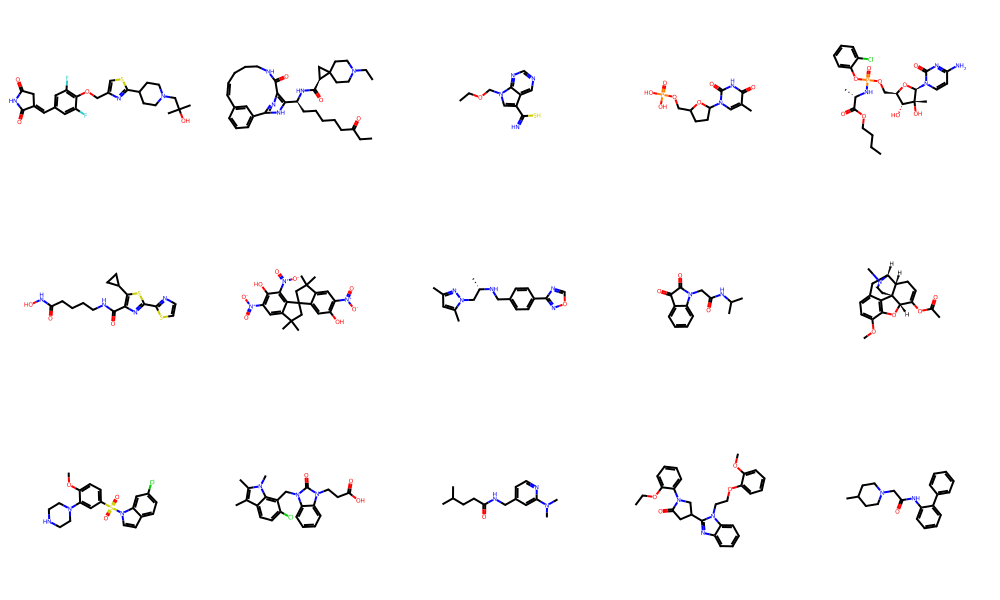

In [18]:
Draw.MolsToGridImage(
    picked_mols_moll,
    molsPerRow=5,
    useSVG=True,
)

## `MaxMinPicker` from RDKit

How fingerprints are calculated:

In [19]:
def smi_to_fp_rdkit(smi) -> np.ndarray | None:
    try:
        mol = Chem.MolFromSmiles(smi)
        fp = AllChem.GetMorganFingerprintAsBitVect(
            mol, FINGERPRINT_RADIUS, FINGERPRINT_SIZE
        )
        return fp
    except:
        print(f"Ignored: {smi}")
        return None

In [20]:
%%time

# Generate fingerprints
fps_rdkit = [
    fp for batch in apply_batches(smiles, smi_to_fp_rdkit, n_batches=1, n_workers=N_WORKERS) for fp in batch
    ]

# Init RDKit picker
rd_picker = MaxMinPicker()

# Pick molecules
rd_picked_idxs = rd_picker.LazyBitVectorPick(
    fps_rdkit, len(fps_rdkit), N_MOL_TO_PICK, seed=42
)

Ignored: Cc1ccc2c(c1)-n1-c(=O)/c=c\c(=O)-n-2-c2cc(C)ccc2-1
CPU times: user 11min 25s, sys: 27.9 s, total: 11min 53s
Wall time: 11min 32s


In [21]:
picked_idxs_rdkit = list(rd_picked_idxs)

## Compare

Compute Tanimoto distances within the subsets of compounds picked by different methods (and randomlly)

In [22]:
fps_moll = jnp.array(fps_moll, dtype=bool)

In [23]:
fps_subset_orgiginal = jax.random.choice(
    jax.random.PRNGKey(42), fps_moll, shape=(N_MOL_TO_PICK,), replace=False
)

fps_subset_moll = picker.points

fps_subset_rdkit = [fps_rdkit[i] for i in picked_idxs_rdkit]

In [24]:
tanimoto_original = jax.vmap(one_minus_tanimoto)(
    fps_subset_orgiginal[:-1], fps_subset_orgiginal[1:]
)

tanimoto_rdkit = jnp.array(
    [
        1 - DataStructs.TanimotoSimilarity(fp1, fp2)
        for fp1, fp2 in zip(fps_subset_rdkit[:-1], fps_subset_rdkit[1:])
    ]
)

tanimoto_moll = jax.vmap(one_minus_tanimoto)(fps_subset_moll[:-1], fps_subset_moll[1:])

Plot histograms of the pairwise distances

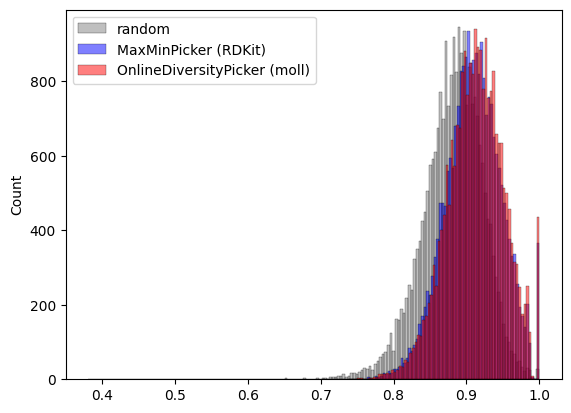

In [25]:
sns.histplot(tanimoto_original, label="random", alpha=0.5, color="gray")
sns.histplot(tanimoto_rdkit, label="MaxMinPicker (RDKit)", alpha=0.5, color="blue")
sns.histplot(
    tanimoto_moll, label="OnlineDiversityPicker (moll)", alpha=0.5, color="red"
)
plt.legend()
plt.show()

Compute average Tanimoto distance within each subset

In [26]:
result = {
    "random": tanimoto_original,
    "rdkit": tanimoto_rdkit,
    "moll": tanimoto_moll,
}

for name, tanimoto in result.items():
    print(f"{tanimoto.mean().item():.3f} for {name}")

0.881 for random
0.909 for rdkit
0.913 for moll


## Conclusion

- `OnlineDiversityPicker` is faster (see **wall time** under the cells with calculations) than `MaxMinPicker` and works online: fingerprints are calculated on the fly on the CPU and the diversity is calculated on the GPU in parallel.
- `OnlineDiversityPicker` is better than a random pick.
- `OnlineDiversityPicker` is comparable (even better in this specific case) to `MaxMinPicker` in terms of diversity.
- Adjusting the `k_neighbors` parameter influences the diversity of the resulting subset, with larger values tending to yield more diversity. However, this increment also affects the speed.